In [1]:
import os
import torch
import ds.paths as d_path
import torchvision

from utils.init import reproducibility, clean_memory_get_device
from config import ConfigArgs
from utils.train import EarlyStopper, TrainingInfo, epoch_end_print, get_dataloaders, get_datasets, check_best, end_train, evaluate, train_one_epoch
from torchvision.models import resnet18, ResNet18_Weights
from utils.plot import plot_losses
from IPython.display import clear_output
from ds.reflacx.chexpert import REFLACXCheXpertDataset
from ds.reflacx.lesion_detection import REFLACXLesionDetectionDataset
from engine.classification import ClassificationEvaluator, load_cl_pretrained, resnet_set_trainable_layers
from models.classification import MultiBinaryClassificationModel
from utils.plot import plot_train

import warnings
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device()
# device = torch.device("cpu")
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large 

In [3]:
image_size = 128
batch_size = 32
epochs = 50
linear_eval = True

In [4]:
from torch import nn
from ds.reflacx.chexpert import REFLACXCheXpertDataset
from utils.train import get_dataloader_g
import torch.utils.data as data
import math
import numpy as np

# load the model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# cl_model_name = "our_improved_v11"

train_d = data.DataLoader(
    REFLACXCheXpertDataset(image_size=image_size, use_aug=False, split_str="train"),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    generator=get_dataloader_g(0),
    drop_last=False,
)


# load weights into this backbone then apply fpn.

# cp = torch.load(
#     os.path.join("checkpoints", cl_model_name, "model"), map_location=device
# )

# backbone_cp_dict = param_dict = {
#     k.replace("img_enc.", ""): v
#     for k, v in cp["model"].items()
#     if k.startswith("img_enc.")
# }

# del backbone_cp_dict['fc.weight']
# del backbone_cp_dict['fc.bias']

# model.load_state_dict(backbone_cp_dict, strict=False)

if linear_eval == True:
    for param in model.parameters():
        param.requires_grad_(False)

model.fc = nn.Linear(
    512,
    train_d.dataset.num_classes(),
)

optimizer = torch.optim.AdamW(
    params=[p for p in model.parameters() if p.requires_grad],
    lr=3e-4,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=math.ceil(len(train_d.dataset) / batch_size)
    * epochs,  # 286,817 is the size of the training dataset. (https://paperswithcode.com/dataset/cnn-daily-mail-1)
    eta_min=1e-8,
)

In [5]:
criterion = nn.BCELoss()

In [6]:
import torch.nn.functional as F

def train_one_epoch(
    model,
    criterion,
    optimizer,
    dataloader,
    device,
    epoch,
    max_norm=0,
    lr_scheduler=None,
):

    model.to(device)
    model.train()
    iters = math.ceil(len(dataloader.dataset) / train_d.batch_size)
    evaluator = ClassificationEvaluator()

    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, iters - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    losses = []
    for i, (x, y) in enumerate(dataloader):
        output = model(x.to(device))
        loss = criterion(F.sigmoid(output), y.to(device).float())
        optimizer.zero_grad()
        loss.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        evaluator.update(F.sigmoid(output), y)
        
        if lr_scheduler is not None:
            if isinstance(
                lr_scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
            ):
                lr_scheduler.step(epoch + i / iters)
            else:
                lr_scheduler.step()
        losses.append(loss.item())
    return (losses, evaluator.get_performance())

@torch.inference_mode()
def evaluate(model, data_loader, device):
    model.to(device)
    model.eval()
    evaluator = ClassificationEvaluator()
    losses = []

    for _, (x,y) in enumerate(data_loader):
        output = model(x.to(device))
        loss = criterion(F.sigmoid(output), y.to(device).float())
        evaluator.update(F.sigmoid(output), y)
        losses.append(loss.item())

    return losses, evaluator.get_performance()

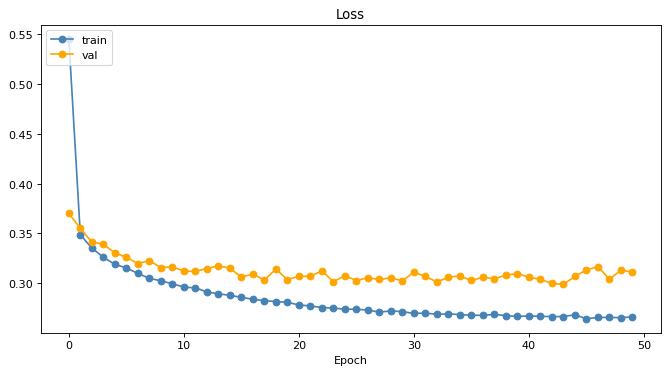

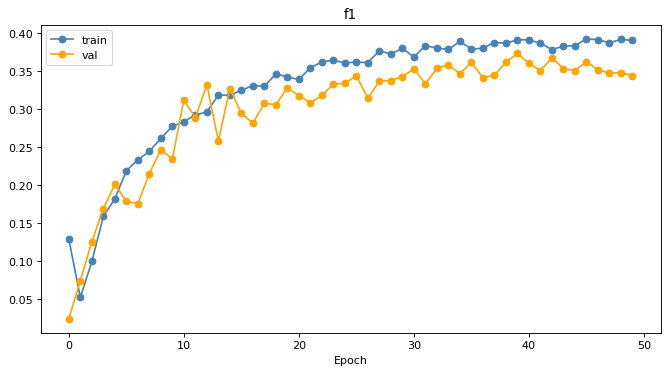

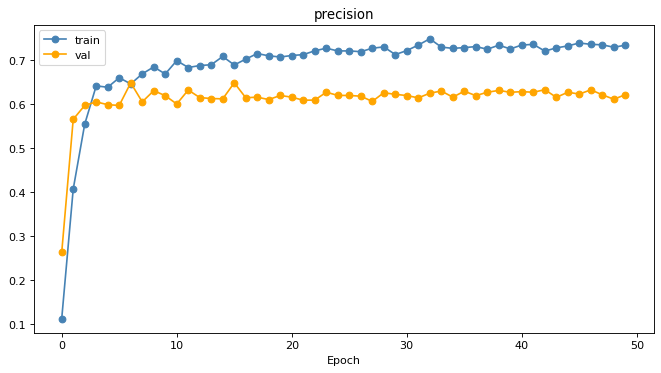

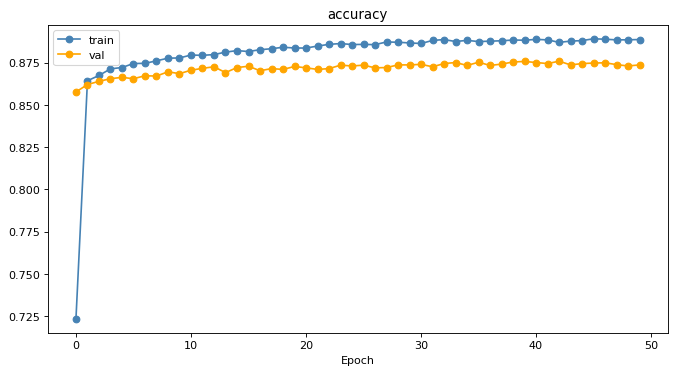

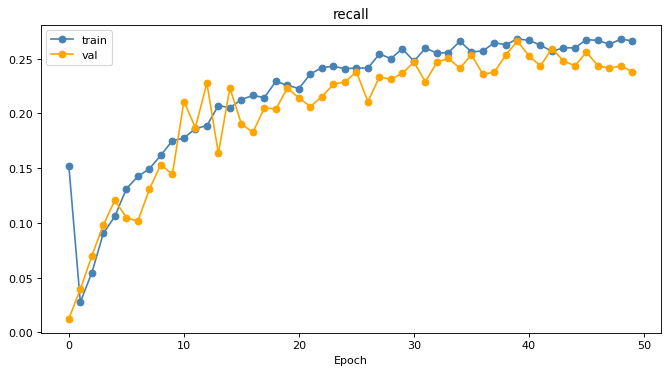

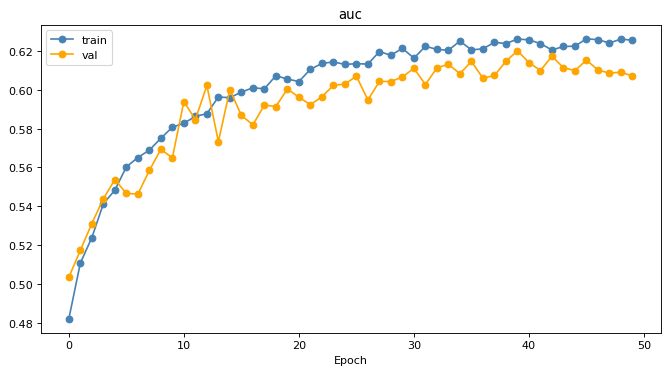

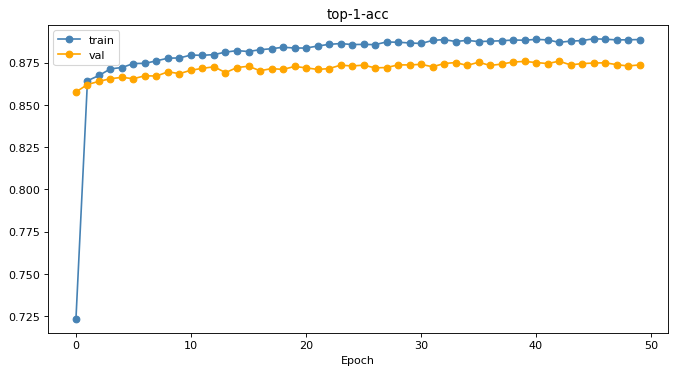

In [7]:
train_losses = []
train_perfs = []

val_losses = []
val_perfs = []

val_d = data.DataLoader(
    REFLACXCheXpertDataset(image_size=image_size, use_aug=False, split_str="val"),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    generator=get_dataloader_g(0),
    drop_last=False,
)


for epoch in range(epochs):
    train_l, train_perf = train_one_epoch(
        model,
        criterion,
        optimizer,
        train_d,
        device,
        epoch,
        max_norm=1,
        lr_scheduler=scheduler,
    )
    val_l, val_perf = evaluate(
        model=model,
        data_loader=val_d,
        device=device,
    )
    val_losses.append(np.mean(val_l))
    val_perfs.append(val_perf)
    train_losses.append(np.mean(train_l))
    train_perfs.append(train_perf)
    clear_output()
    plot_train(train_losses, val_losses, title="Loss")
    for m in train_perfs[0].keys():
        plot_train(
            [p[m] for p in train_perfs],
            [p[m] for p in val_perfs],
            m,
        )

In [8]:
test_d = data.DataLoader(
    REFLACXCheXpertDataset(image_size=image_size, use_aug=False, split_str="test"),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    generator=get_dataloader_g(0),
    drop_last=False,
)

test_p = evaluate(
    model=model,
    data_loader=test_d,
    device=device,
)

In [9]:
# ([0.34064996242523193,
#   0.2830096483230591,
#   0.26946622133255005,
#   0.30221304297447205,
#   0.22647912800312042,
#   0.22984877228736877,
#   0.2798682451248169,
#   0.2937351167201996,
#   0.2840029001235962,
#   0.3246776759624481,
#   0.3224404454231262,
#   0.3493787944316864,
#   0.2330457866191864,
#   0.25969451665878296,
#   0.21234315633773804],
#  {'f1': 0.39193548387096777,
#   'precision': 0.662125340599455,
#   'accuracy': 0.8816326530612245,
#   'recall': 0.27835051546391754,
#   'auc': 0.6278963783432012,
#   'top-1-acc': tensor(0.8816)})

In [10]:
# # 100 epochs

# ([0.3376217782497406,
#   0.28317463397979736,
#   0.2637411952018738,
#   0.30325421690940857,
#   0.2285563200712204,
#   0.22325687110424042,
#   0.2721404731273651,
#   0.2980673015117645,
#   0.2666020393371582,
#   0.32698938250541687,
#   0.32367292046546936,
#   0.34797030687332153,
#   0.227940633893013,
#   0.2547491192817688,
#   0.21853138506412506],
#  {'f1': 0.42154566744730676,
#   'precision': 0.6617647058823529,
#   'accuracy': 0.8836734693877552,
#   'recall': 0.30927835051546393,
#   'auc': 0.6420868740025019,
#   'top-1-acc': tensor(0.8837)})

In [11]:
test_p

([0.34778648614883423,
  0.29302069544792175,
  0.29869216680526733,
  0.3125295639038086,
  0.23612281680107117,
  0.2726960778236389,
  0.2717995345592499,
  0.32173535227775574,
  0.28876420855522156,
  0.34229451417922974,
  0.33745840191841125,
  0.3539806604385376,
  0.2675688564777374,
  0.2574625015258789,
  0.2746451199054718],
 {'f1': 0.34516928158546656,
  'precision': 0.6183431952662722,
  'accuracy': 0.8755102040816326,
  'recall': 0.23940435280641467,
  'auc': 0.6079685034907096,
  'top-1-acc': tensor(0.8755)})